# Algotrading

A pet project aimed at predicting a cryptocurrency price based on data from polymarket.com

## Problem definition


**Meta**: Try to make minimal possible solution & move to more complex ones if a simple one does not perform as we wish it to.

**A goal** is to check whether there is a correlation between crypto currencies (CC) price in the future with & polymarket polls about them.


## Available datapoints are


- CC price from Binance (target)

**Polymarket has polls of varying types**, but at its core, there is a single (Yes/No) bet. Polls of choice type are just an ordered list of (Yes/No) polls.

Some of the polls formats:
- (Choice) Price range prediction of CC at a time point
- (Choice) Min price pred. at a time point
- (Choice) When will a CC reach an all time high
- (Yes/No) Will a CC reach an all time high before some time point
- (Yes/No) Will a CC be above some price at a time point?
- etc.


**Each poll has these datapoints**:
- Total volume in USD
- End date
- For each option to make a bet on, there is a "chance" of it happening, computed using bets distribution.
- How "chance" of an event was changing over time (a graph, chart)
- Price for 100 shares. When placing a bet, user is buying shares. In the UI price per 100 shares is shown. Price of a single share varies between 0 and 1. When a bet is resolved and user made a winning bet, every share is exchanged to 1.
- Distribution of how much shares were purchased at what price for each betting option
- Comments on a poll. They can also be replies to top-level comments.
	- Content, text
	- Amount of likes
	- Shares he has on a poll. Note: multiple bets can be placed on a single poll. Total shares amount he has & for which option is shown. It means it is not shown how much money he spent, as share price has a varying price.
- 15 top holders of each option
- Recent activity: who purchased or sold shares and at what cost
- A list of related polls. Potentially, we could extract data from these polls too. For example, for a poll "Bitcoin above 105,000 on January 31?" its related bet can be "Will Bitcoin reach 110_000 by January 31, 2025"

**We can view top users** by their betting volume & profit. **Their bets could be mimiced**.
Looks like a bot to me: https://polymarket.com/profile/0x42a6ddf7cf7032972b0bfe32775e8109c5171b64?tab=activity


## Visual analysis


I've placed 2 charts side my side: BCT Price and Polymarket confidence in BTC hitting a price of 120k by March 31. Visually it can be seen that Polymarket roughly mimics the BTC price trend, which had never reached this price point, typically being in a range of 95k-105k.

Notably, other polymerket polls - 110k, 130k, 150k, 200k have a similar shape, where bigger the poll price (200k), less similar (mimicing its up's and down's) it is to a BTC price at that time.

Binance BTC Price Chart            |  Market confidence in "BTC will hit 120k by March 31" 
:-------------------------:|:-------------------------:
![image.png](../static/1_binance_btc_chart.png)  |  ![image.png](../static/1_polymarket_BTC_hit_120k.png)


Next observation is, that polls that bet on a lower outcome than the current price have a negative correlation, meaning that when more people bet "Yes" on 120k, more people vote "No" on 80k.

Market confidence in "BTC will hit 120k by March 31"
![image.png](../static/1_polymarket_BTC_hit_120k.png)  

Market confidence in "BTC will hit 80k by March 31"
![image.png](../static/1_polymarket_BTC_hit_80k.png)


## Short-term correlation of BTC price and polymarket polls

I have attempted to make a correlation between polymarket probabilities and BTC price changes. Below it is shown that they indeed are correlated in short term.

In [38]:
import importlib
from datetime import datetime

import numpy as np

import poly_datasets
import poly_api
import binance_datasets
import analysis

In [39]:
def analyze_poly_markets(
    markets: list[poly_datasets.PMDataset],
    fidelity: int,
    corr_offset_amplitude: int,
    strip_percent: int | None = None,
    max_corr_threshold: float = 0.0,
):
    print(f"Analyzing {len(markets)} markets")

    # Remove first and last X% of datapoints for more stability.
    # At the start probability is 0.5
    #   -> Not useful TODO: Explain
    # At the end people are much more confitend because time is up
    #   -> probability is around 0 or 1
    #   -> Not useful TODO: Explain
    stripped_markets: list[poly_datasets.PMDataset] = []
    if strip_percent is not None:
        for market in markets:
            start_idx = len(market.index) // strip_percent
            end_idx = len(market.index) - start_idx

            stripped_markets.append(
                market.subset(
                    market.index[start_idx],
                    market.index[end_idx],
                )
            )
    else:
        stripped_markets = markets

    # Remove markets with insufficient data
    filtered_markets: list[poly_datasets.PMDataset] = []
    for idx in range(len(markets)):
        market = stripped_markets[idx]
        if len(market.open) < corr_offset_amplitude * 2:
            print(f"Skipping `{market.label}` due to insufficient data")
            continue

        filtered_markets.append(market)

    binance_df = binance_datasets.load_matching_binance_data(filtered_markets, fidelity)
    binance_deltas = [
        binance_df.loc[market.index, "delta"] for market in filtered_markets
    ]

    # Compute correlations with offset
    corr_coef = analysis.compute_delta_correlation(
        filtered_markets, binance_deltas, corr_offset_amplitude
    )

    # Get rid of weakly correlated markets
    end_corr_coef = []
    end_markets = []

    for idx, corr in enumerate(corr_coef):
        market = filtered_markets[idx]
        if np.max(corr) <= max_corr_threshold:
            print(
                f"Skipping `{market.label}` due to low correlation (corr < {max_corr_threshold})"
            )
            continue

        end_corr_coef.append(corr)
        end_markets.append(market)

    print(f"Plotting {len(end_markets)} markets")

    analysis.plot_delta_correlation(
        end_markets, binance_df, end_corr_coef, corr_offset_amplitude
    )

Analyzing 14 markets
Skipping `will-bitcoin-dip-to-90000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-85000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-80000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-70000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-60000-by-january-31-2025` due to low correlation (corr < 0.1)
Plotting 9 markets


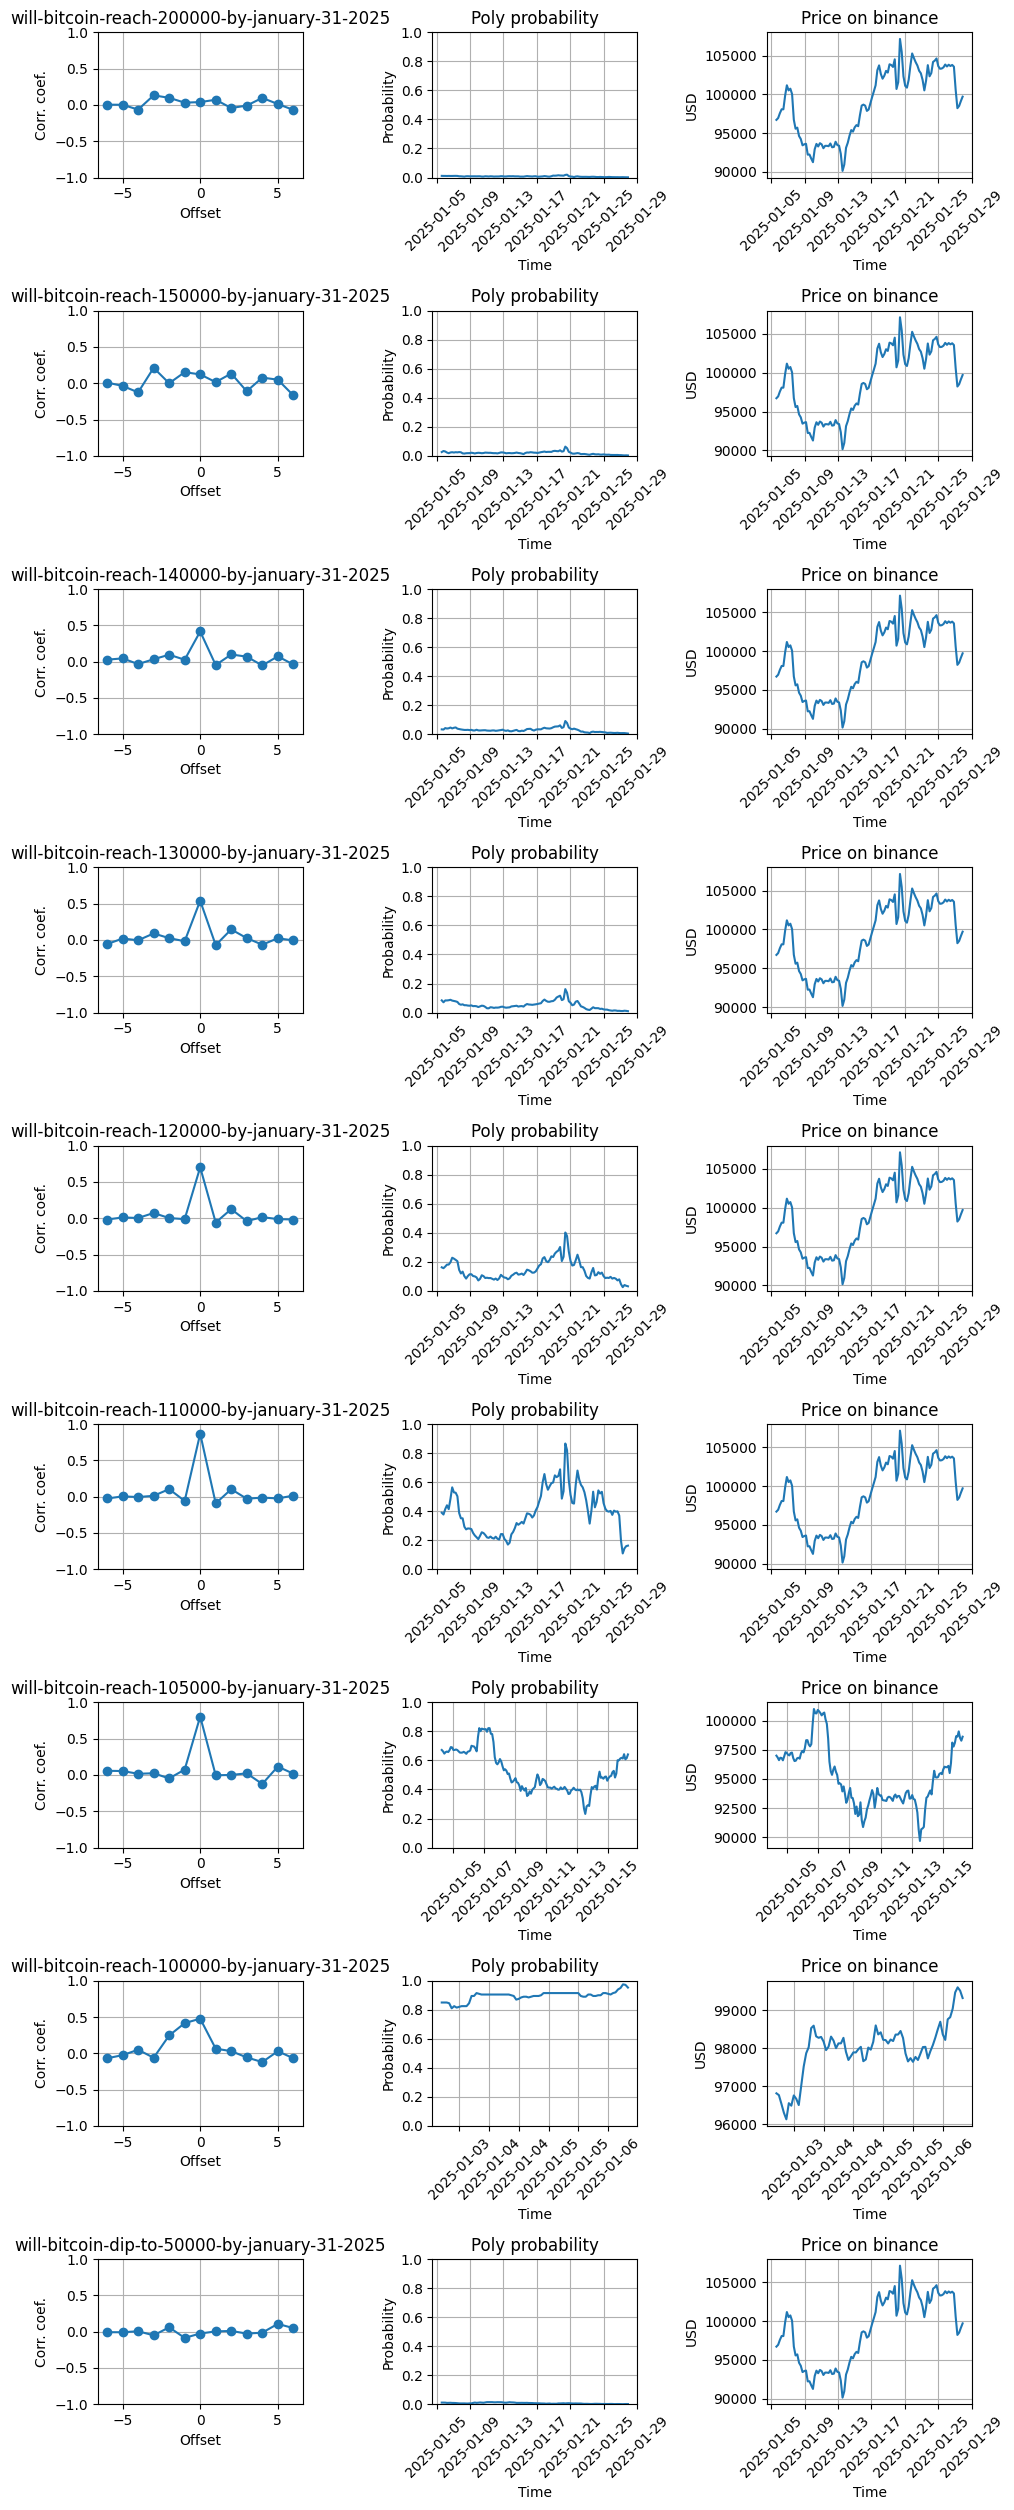

In [40]:
# Same markets as in 2_pm_BTC_1(d|h).csv
market_ids = "0xc2c1038424a37a044781d1915e82ddbea1515d79cdb8966a2bf0a658b178b21c,0x69c7ea583787dee4228468864414f33c84c3ab58c2eaba37ca7a5c0aed4e899e,0xd7fa09afd9c184f94edb6f15f5f98640dc3f5418ffbd520a10ef3f4775414c73,0x78dd44195111f89210b059180792a1fa156d1f211392e76575dc36846e815987,0x7c662197ecf9c6c2441c1cb57e8c8a761a5782eeb0c219dc14daf3f165d188a1,0x0f3131c874579825ecdbbda8c7aeed071aa908d7c993792c393285900e68906f,0x44c5b4d851e8c06698c13b54e8ba33e37637e13bdb3f375ce0b6727b2aa06b48,0x0bdabf234110590a6475e88f386ec7512f0f0d8038989e39259f0eb995650594,0xcdab757d22e9ca242163475ed1426e6a8d2c9a579b39198f7cec223024ee2e89,0x8d29692749f246da11fb329a2ecaf95d08cc6c97d3f8ebe0c052d1ce42057595,0xda728da52dda8a465dd49a1e9a6daa000b2116bd799b18ec383c68e68c693bda,0x263c7f77dc9cc2a68ce238794051b4801ae0d0aa0b1242a54726a8860a1809e8,0xd100eaa5eb47d06b9f3f4ff37ad34c1e588b3f322cd8d7d408c379a2ce3ea03e,0x906a2b90f30c62e09dce56fababafafbc4338cb8dac94ac6c3038327d0447180".split(
    ","
)

# Load data with 3 minutes interval between samples
fidelity = 60
ts_options = poly_api.TSOptions(
    fidelity,
    (
        datetime.fromisoformat("2025-01-02 19:00"),  # Market start date
        datetime.fromisoformat("2025-01-30 23:00"),  # Market end date
    ),
)
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)


analyze_poly_markets(
    processed_markets,
    fidelity,
    corr_offset_amplitude,
    strip_percent=10,
    max_corr_threshold=0.1,
)

Analyzing 14 markets
Skipping `will-bitcoin-reach-200000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-85000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-80000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-70000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-60000-by-january-31-2025` due to low correlation (corr < 0.1)
Skipping `will-bitcoin-dip-to-50000-by-january-31-2025` due to low correlation (corr < 0.1)
Plotting 8 markets


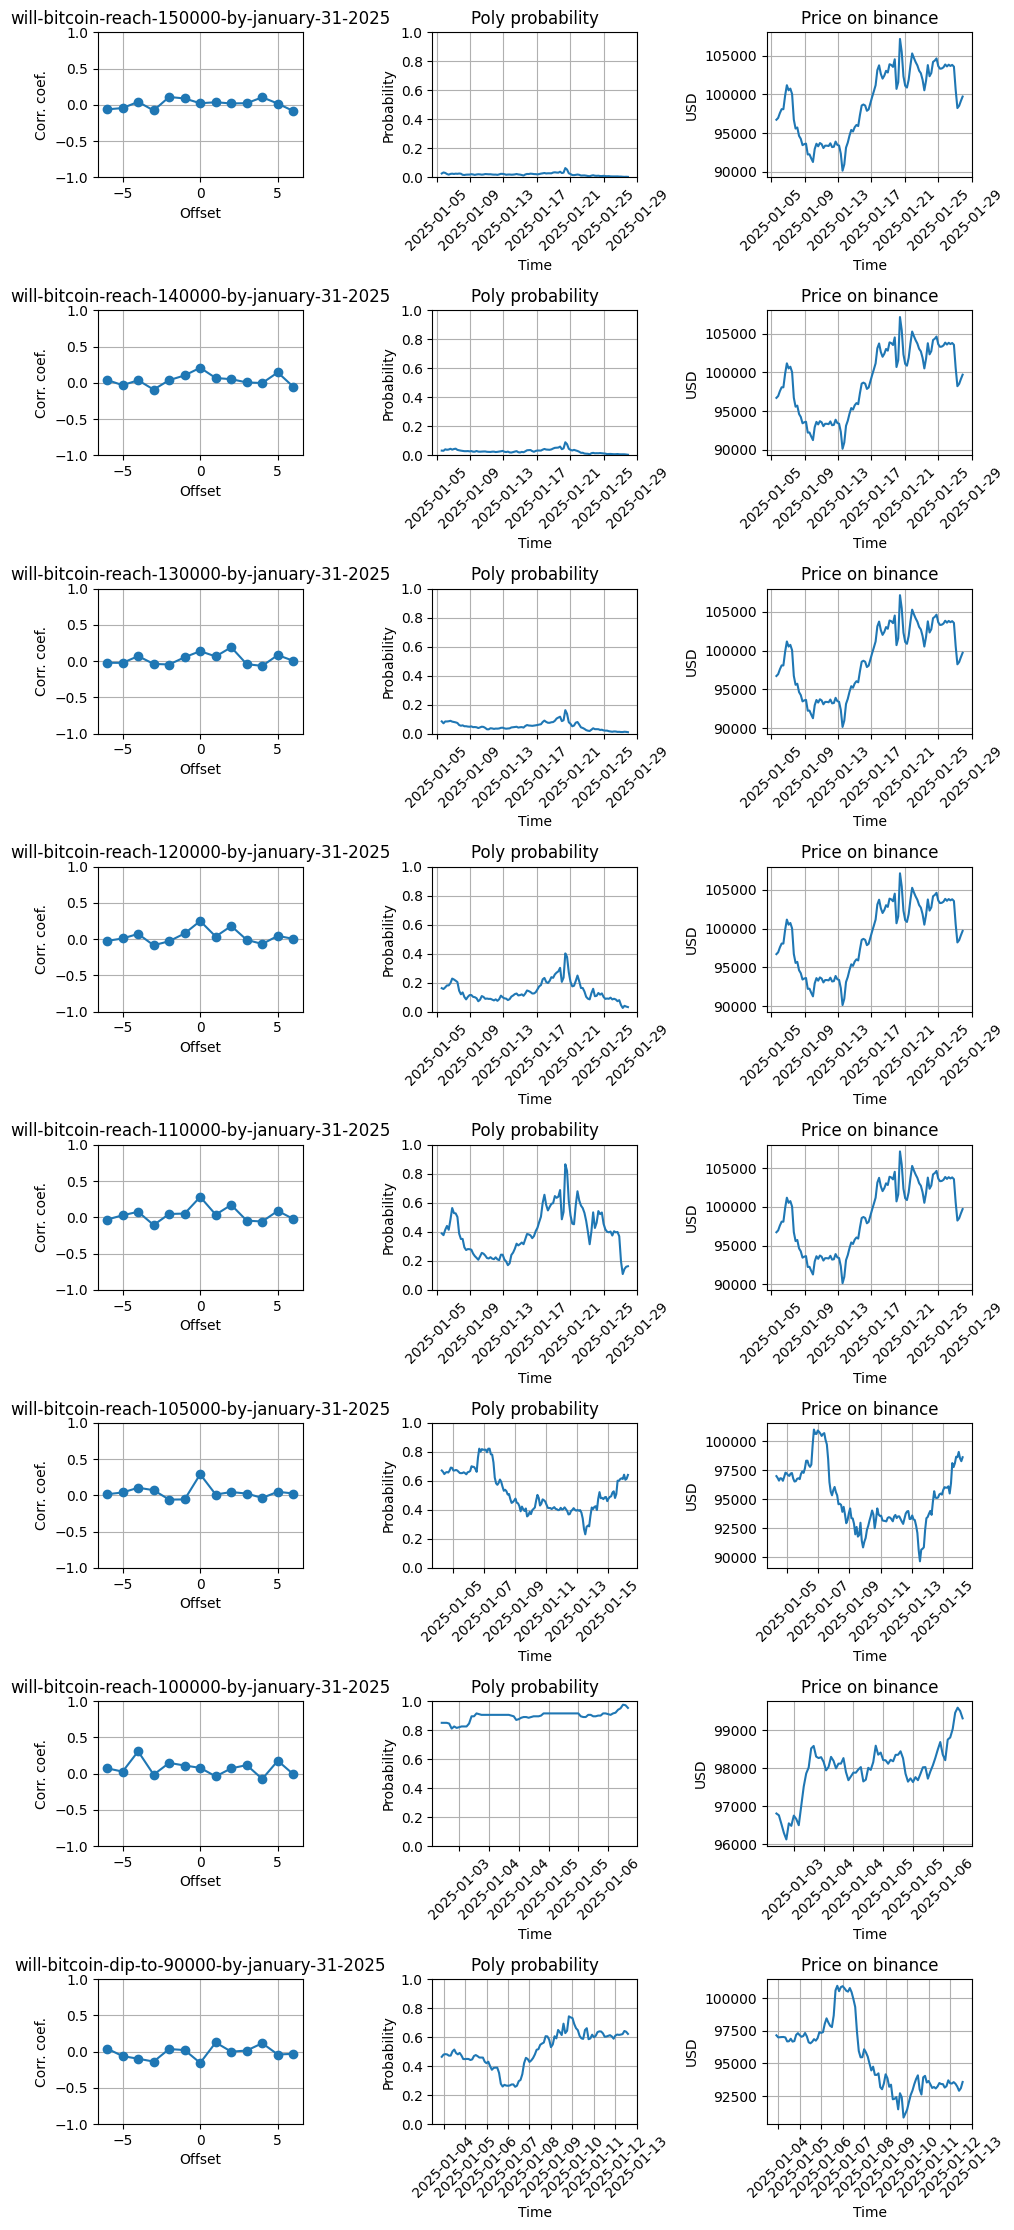

In [41]:
# Load data with 3 minutes interval between samples
fidelity = 3
corr_offset_amplitude = 6
raw_markets = poly_api.load_markets_data(market_ids, ts_options)
processed_markets = poly_datasets.process_pm_df(raw_markets)


analyze_poly_markets(
    processed_markets,
    fidelity,
    corr_offset_amplitude,
    strip_percent=10,
    max_corr_threshold=0.1,
)

### Correlations plot interpretation



Each row represents a market, a slug of which is written on the plot's left side.

There are 3 columns per row:
1. Correlation coef. on y axis after applying an offset shown on x axis.
2. Polymarket probability over time.
3. Binance BTC price over time.



At offset 0, there is a notable positive correlation on bets that BTC will grow, and notable negative correlation that BTC will loose in its price, which can indicate that most of the market reponds to BTC's price change reactively.

An offset indicates how were polymarket probabilites shifted. 1 offset equates to 3 minutes shift. I'm yet unable to get data with a 1 minute interval between datapoints.
- When correlation is positive -> Polymarket changes ahead of BTC price.
- When correlation is negative -> Polymarket changes after BTC changes.
- When correlation is zero -> They change at a similar time interval.



Some markets were omitted because there wasn't any notably high correlation with a given offset amplitude. 

The same markets were plotted but with different intervals between datapoints(fidelity).

As can be seen on plots, polymarket does not seem to have a predictive power over binance BTC price, because positive offsets are at around 0.

Although, there is a tail of notable correlations on negative offsets, which means that btc price has some predictive power over polymarket probabilities.

Upd: This correlation seems to be caused by noise traders.


### Next